In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] ='/content'
!kaggle datasets download -d yasserh/breast-cancer-dataset
!unzip \*.zip && rm *.zip

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 48.6MB/s]
Archive:  breast-cancer-dataset.zip
  inflating: breast-cancer.csv       


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define a function to calculate local density using k-nearest neighbors density estimation
def calculate_local_density(X, k=3):
    # Calculate distances to k nearest neighbors for each data point
    knn_distances = np.sort(np.linalg.norm(X[:, np.newaxis] - X, axis=2), axis=1)[:, 1:k+1]
    # Estimate local density as the inverse of the average distance to k nearest neighbors
    local_density = 1 / np.mean(knn_distances, axis=1)
    return local_density

# Step 1: Load Data
data = pd.read_csv('/content/breast-cancer.csv')

# Assuming 'diagnosis' is the target variable
X = data[['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
          'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']]
y = data['diagnosis']  # Target variable

# Step 2: Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Model Training - LAKNN
# Calculate local density for training data
local_density_train = calculate_local_density(X_train_scaled)

# Set k values proportional to local density
k_values_train = np.ceil(local_density_train * 10).astype(int)

# Initialize list to store predictions
y_pred = []

# Classify each test data point using KNN with locally adaptive k
for i, x_test_point in enumerate(X_test_scaled):
    # Calculate distances to training data points
    distances = np.linalg.norm(X_train_scaled - x_test_point, axis=1)
    # Sort distances and select the k nearest neighbors
    nearest_neighbors_indices = np.argsort(distances)[:k_values_train[i]]
    # Use the majority class among the nearest neighbors as the predicted class
    nearest_neighbors_classes = y_train.iloc[nearest_neighbors_indices]
    predicted_class = nearest_neighbors_classes.mode()[0]  # Get the mode (most frequent class)
    y_pred.append(predicted_class)

# Step 5: Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9736842105263158
Precision: 0.9737190197716513
Recall: 0.9736842105263158
F1 Score: 0.9736214250146138
Classification Report:
               precision    recall  f1-score   support

           B       0.97      0.99      0.98        71
           M       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



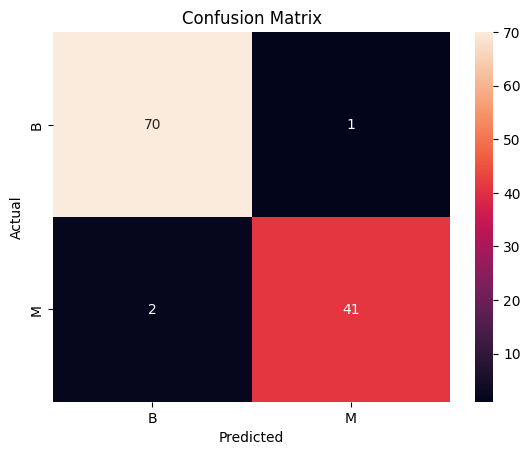

In [3]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.show()